# **THOT calibration**

_by Felix Eickemeyer_

Calibration of raw data.

In [2]:
import re
import os
import sys

from thot import ThotProject
import matplotlib.pyplot as plt

from FTE_analysis_libraries import PLQY as lqy
from FTE_analysis_libraries import Spectrum as spc

import pkg_resources

In [3]:
system_dir = pkg_resources.resource_filename('FTE_analysis_libraries', 'System_data')
cal_lamp_dir = pkg_resources.resource_filename('FTE_analysis_libraries', 'System_data/Calibration_lamp_spectra')

In [5]:
# Initializes Thot project
db = ThotProject( dev_root = 'PLQY_results\PLQY' )

In [6]:
# File extension for raw data
file_ext = 'csv'
# file_ext = 'asc'

# Gigahertz calibration lamp
lamp_spec_FN = 'caldata-BN-LH250-V01_sn51102-LH250_snL2229-200805.txt'
hole_diameter = 3e-3  # m

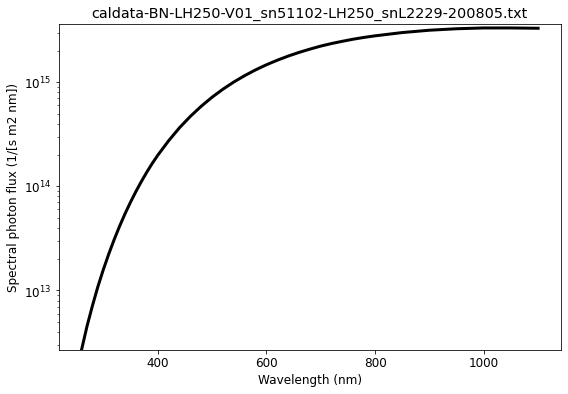

In [7]:
# Load lamp calibration file
lampspec_irr = spc.PEL_spectrum.load(cal_lamp_dir, lamp_spec_FN, header = 1, delimiter = '\t', 
                             quants = dict(x = 'Wavelength', y = 'Spectral irradiance'), units = dict(x = 'nm', y = 'W/[m2 nm]'))

# lampspec = lamp_calib * 1 # change for absolute calibration taking into account excitation port aperture of integrating sphere
lampspec = lampspec_irr.irradiance_to_photonflux(factor = 1e-6/1e-4)
# plot_first_n_lines(cal_lamp_dir, lamp_spec_FN, n=20)
lampspec_graph = lampspec.plot(yscale = 'log', return_fig = True, show_plot = (False and db.dev_mode()))
lqy.add_graph(db, 'lampspec.png', lampspec_graph)

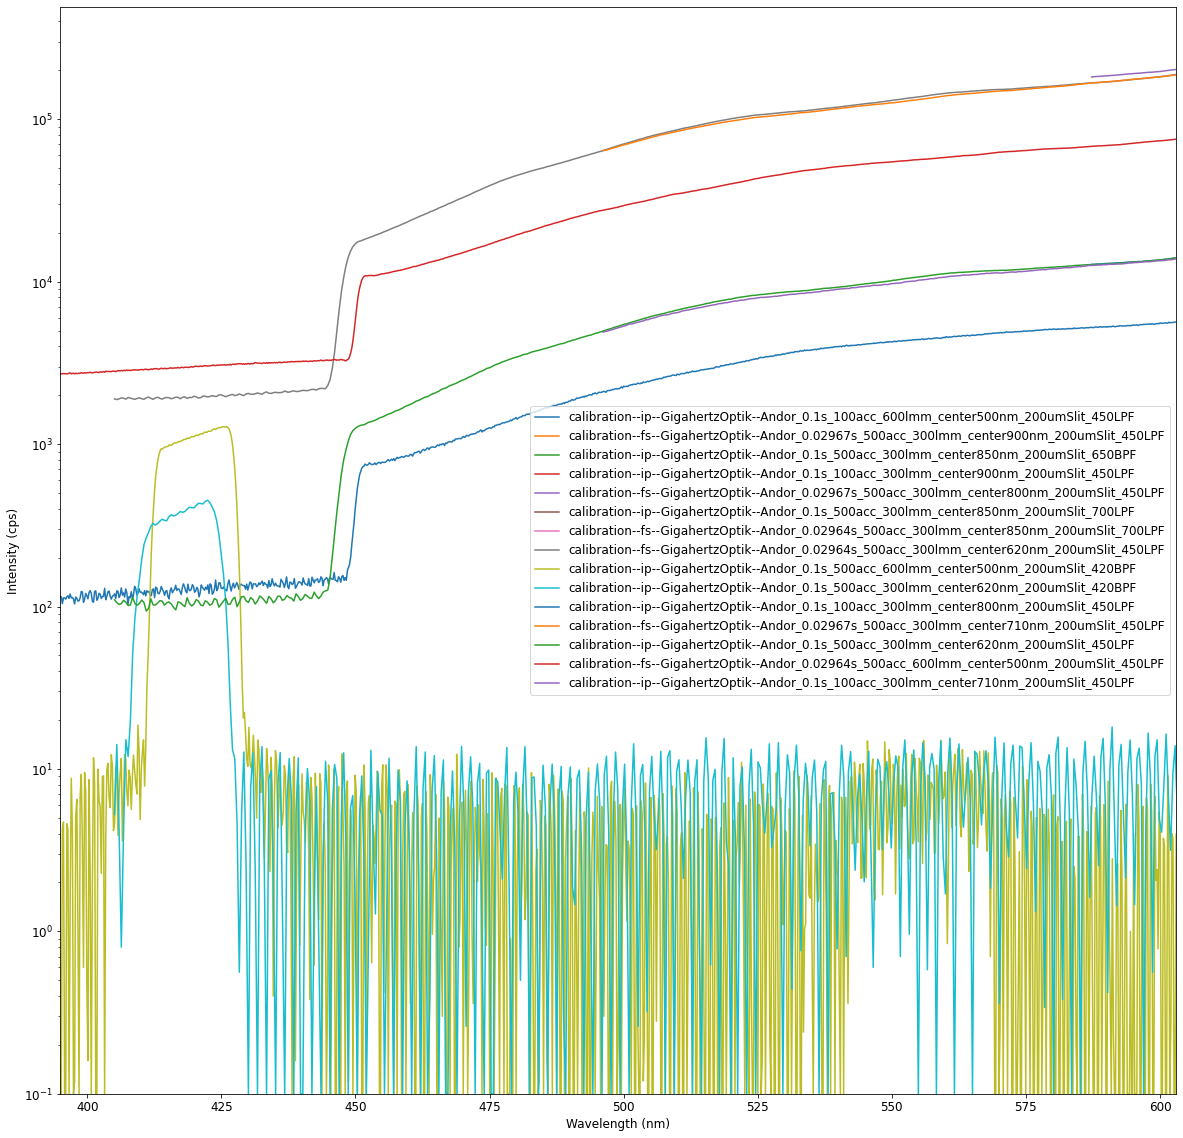

In [8]:
# Load measured calibration spectra
rawcalib = db.find_assets({'type' : 'raw calibration'})
#print(dir(rawcalib[1]))
#print(rawcalib[3].file)
#print(rawcalib[1].metadata)
sa = []
for i, asset in enumerate(rawcalib):
    fp = asset.file
    fn = os.path.basename(fp)
    directory = os.path.dirname(fp)
    acc = asset.metadata['acc']
    int_s = asset.metadata['int_s']

    calib = spc.PEL_spectrum.load(
        directory,
        fn,
        quants = dict(x = 'Wavelength', y = 'Intensity'),
        units = dict(x = 'nm', y = 'cps')
    )
    
    calib.y = calib.y / (int_s * acc)
    sa.append(calib)

calib = spc.PEL_spectra(sa)
calib.names_to_label('.' + file_ext)

# Make sure that no data value is < min (especially not 0 or negative)
calib.all_values_greater_min(min = 1e-1)        

calibspec_graph = calib.plot(
    yscale = 'log',
    figsize = (20, 20),
    return_fig = True,
    show_plot = (True and db.dev_mode())
)

lqy.add_graph(db, 'calibration_spectra.png', calibspec_graph)

Attention: bottom = 0, use a divisor to self-define the bottom = top/divisor, here divisor = 1e8 is used as standard!


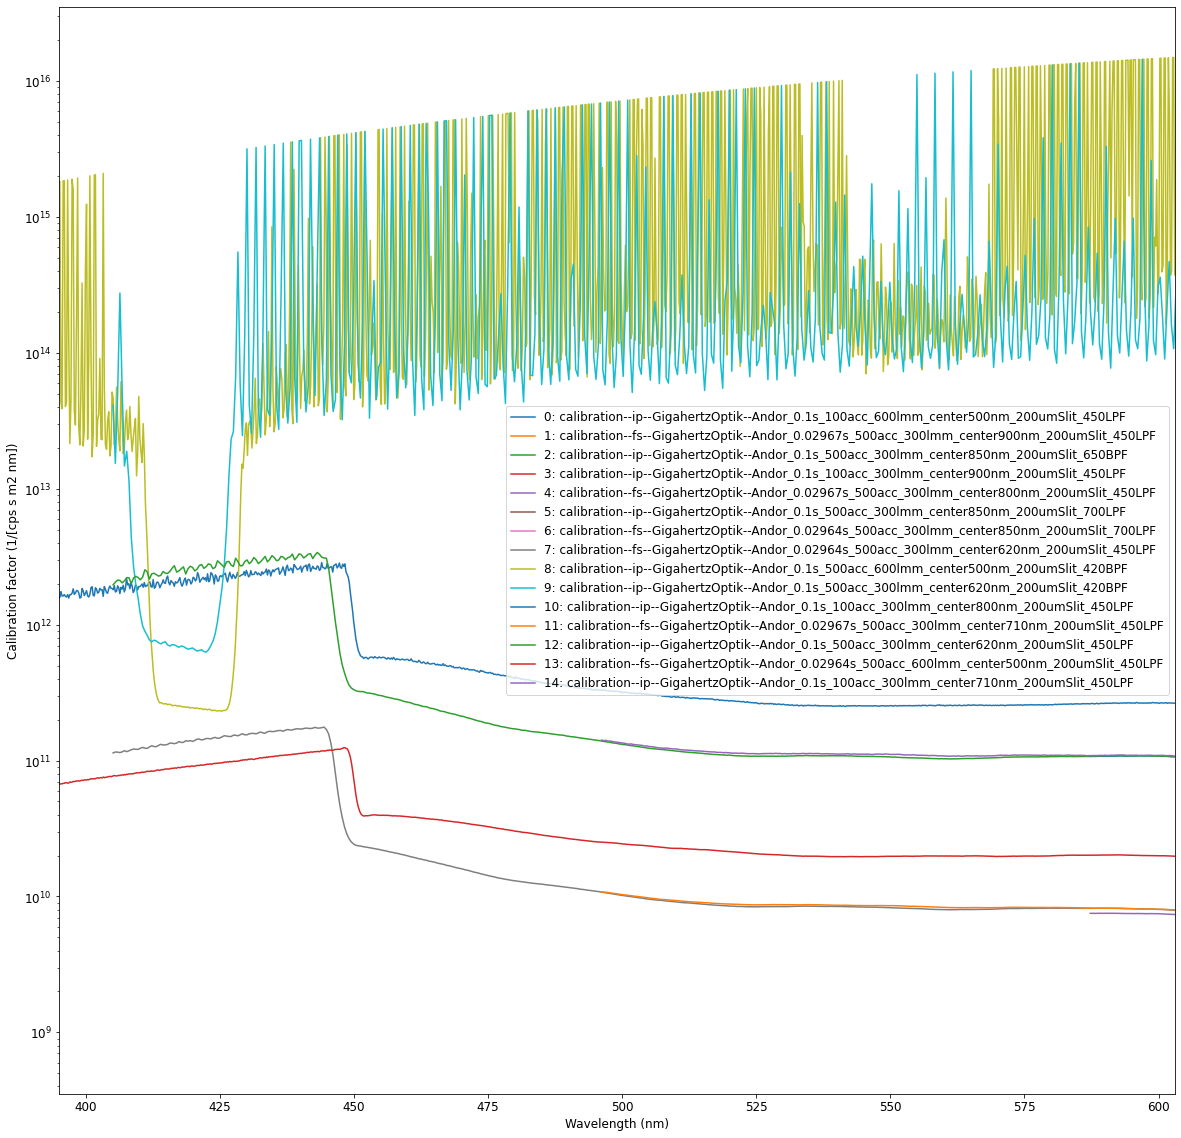

In [9]:
# Calculate calibration function. This function is multiplied with all cps data to yield photon flux
calibfn = spc.PEL_spectra.calc_calfn(calib, lampspec)
calibfn.names_to_label('.csv')

calibfn_graph = calibfn.plot(
    yscale = 'log',
    showindex = True,
    figsize = (20, 20),
    return_fig = True,
    show_plot = (True and db.dev_mode())
)

lqy.add_graph(db, 'calibration_function.png', calibfn_graph)

In [10]:
# Plot single calibration function
do_this_step1 = False
if do_this_step1:
    idx = 3
    # cal_lamp_Andor.sa[idx].plot(yscale = 'linear')
    calibfn.sa[idx].plot(yscale = 'log', bottom = 8e8, top = 10e10)

In [11]:
# Savgol filter for selected calibration function (700 LP free space)
do_this_step2 = False
if do_this_step2:
    idx = 3
    calibfn_old = calibfn.sa[idx]
    calibfn_new = calibfn_old.savgol(n1 = 11, n2 = 1)
    both = spectra([calibfn_old, calibfn_new])
    both.label(['original', 'savgol'])
    both.plot(yscale = 'log', bottom = 8e8, top = 2e9, title = calibfn.sa[idx].name)
    take_over_calib_new = True
    if take_over_calib_new:
        calibfn.sa[idx] = calibfn_new

In [12]:
# Load all PL raw spectra
rawsamples = db.find_assets({'type' : 'raw PL spectrum'})
# print(rawsamples)
# print(rawsamples[1].file)
# print(rawsamples[1].metadata)
sa = []
for i, asset in enumerate(rawsamples):
    fp = asset.file
    fn = os.path.basename(fp)
    directory = os.path.dirname(fp)
    acc = asset.metadata['acc']
    int_s = asset.metadata['int_s']
    rawPLspectrum = spc.PEL_spectrum.load(
        directory,
        fn,
        quants = dict(x = 'Wavelength', y = 'Intensity'),
        units = dict(x = 'nm', y = 'cps')
    )
    
    rawPLspectrum.y = rawPLspectrum.y / (int_s * acc)
    sa.append(rawPLspectrum)
    
rawPLspectra = spc.PEL_spectra(sa)
rawPLspectra.names_to_label('.' + file_ext)
#rawPLspectra.plot(yscale = 'log',figsize = (20,20), divisor = 1e7, showindex = True)    

In [13]:
# Plot single raw spectrum
do_this_step3 = False
if do_this_step3:
    idx = 59
    rawPLspectra.sa[idx].plot(yscale = 'linear', left = PL_signal_left, right = PL_signal_right, figsize = (20,10))    

Calibrate

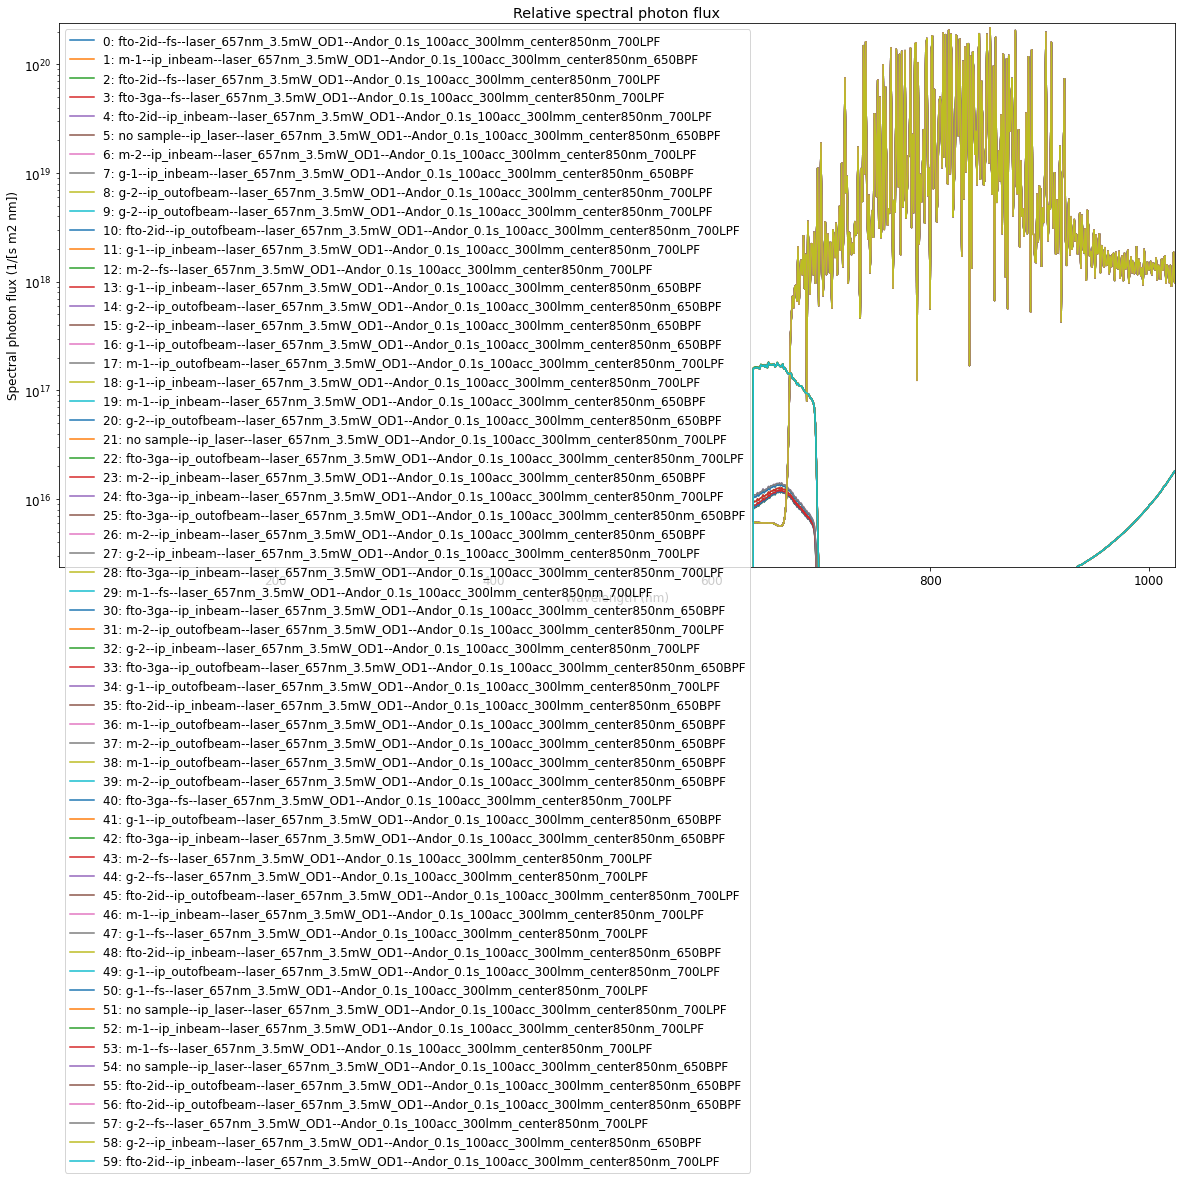

In [14]:
# Calibrate PL spectra
PLspectra_nm = rawPLspectra.calibrate(calibfn, check = False)
PLspectra_nm.names_to_label(split_ch = '.' + file_ext)

calib_PLspectra_graph = PLspectra_nm.plot(
    yscale = 'log',
    divisor = 1e5,
    title = 'Relative spectral photon flux',
    showindex = True,
    figsize = (20, 10),
    return_fig = True,
    show_plot = (False and db.dev_mode())
)

lqy.add_graph(db, 'calib_PLspectra.png', calib_PLspectra_graph)

Create new asset

In [15]:
for idx, sp in enumerate(PLspectra_nm.sa):
    if db.dev_mode():
        print(sp.name)
        
    asset = db.find_asset({'metadata.orig_fn' : sp.name})
    metadata = asset.metadata
    #print(metadata)
    #asset_prop = dict(name = 'calibrated_'+asset.name, type = 'calibrated PL spectrum', metadata = metadata)
    name = metadata['name']
    asset_prop = dict(
        name = f'{idx}_{name}_calibrated PL spectrum.csv',
        type = 'calibrated PL spectrum',
        metadata = metadata
    )
    
    TFN = db.add_asset(asset_prop)
    fn = os.path.basename(TFN)
    if db.dev_mode():
        print(f'{idx: 3}: {fn}') 
    
    directory = os.path.dirname(TFN)
    sp.save(directory, fn, check_existing = False)


fto-2id--fs--laser_657nm_3.5mW_OD1--Andor_0.1s_100acc_300lmm_center850nm_700LPF.csv
  0: 0_fto-2id_calibrated PL spectrum.csv
m-1--ip_inbeam--laser_657nm_3.5mW_OD1--Andor_0.1s_100acc_300lmm_center850nm_650BPF.csv
  1: 1_m-1_calibrated PL spectrum.csv
fto-2id--fs--laser_657nm_3.5mW_OD1--Andor_0.1s_100acc_300lmm_center850nm_700LPF.csv
  2: 2_fto-2id_calibrated PL spectrum.csv
fto-3ga--fs--laser_657nm_3.5mW_OD1--Andor_0.1s_100acc_300lmm_center850nm_700LPF.csv
  3: 3_fto-3ga_calibrated PL spectrum.csv
fto-2id--ip_inbeam--laser_657nm_3.5mW_OD1--Andor_0.1s_100acc_300lmm_center850nm_700LPF.csv
  4: 4_fto-2id_calibrated PL spectrum.csv
no sample--ip_laser--laser_657nm_3.5mW_OD1--Andor_0.1s_100acc_300lmm_center850nm_650BPF.csv
  5: 5_no sample_calibrated PL spectrum.csv
m-2--ip_inbeam--laser_657nm_3.5mW_OD1--Andor_0.1s_100acc_300lmm_center850nm_700LPF.csv
  6: 6_m-2_calibrated PL spectrum.csv
g-1--ip_inbeam--laser_657nm_3.5mW_OD1--Andor_0.1s_100acc_300lmm_center850nm_650BPF.csv
  7: 7_g-1_calib

In [16]:
if not db.dev_mode():
    sys.exit()

# Supplemental code

In [17]:
#Plot all data normalized within [left, right]
do_this = False
if do_this:
    left = PL_signal_left
    right = PL_signal_right

    spa2 = PLspectra_nm.copy()
    spa2.names_to_label()
    for idx, sp in enumerate(spa2.sa):
        r = range(findind(sp.x, left), findind(sp.x, right))
        print(f'{sp.name}: max = {max(sp.y[r]):.1e}')
        sp.normalize(x_lim = [left, right])
        m = 1

    #spa2.plot(yscale = 'log', title = 'Relative spectral photon flux', left = left, right = right, bottom = m*1e-2, top = m*1.1, figsize = (30, 20), nolabel = False)

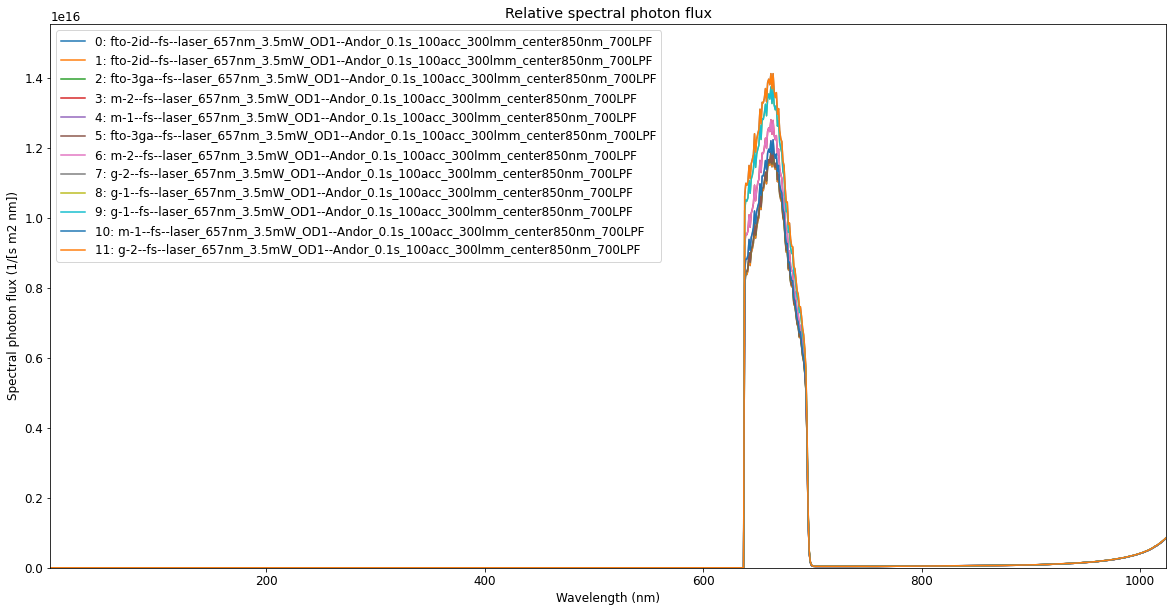

In [18]:
PLspectra_nm.plot(yscale = 'linear', bottom = 0, title = 'Relative spectral photon flux', showindex = True, figsize = (20, 10), in_name = ['fs'])